In [1]:
import json
from ts_main import run_ts, parse_input_dict
from baseline import enumerate_library
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from tqdm.auto import tqdm
import numpy as np
from evaluators import FPEvaluator
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

Enable Pandas progress_apply

In [2]:
tqdm.pandas()

In [3]:
TS_BASE_DIR = "."

Define JSON for the reaagents, reaction, and evaluation function.

In [4]:
quinazoline_json = """{
"reagent_file_list": [
        "TS_BASE_DIR/data/aminobenzoic_100.smi",
        "TS_BASE_DIR/data/primary_amines_100.smi",
        "TS_BASE_DIR/data/carboxylic_acids_100.smi"
    ],
    "reaction_smarts": "N[c:4][c:3]C(O)=O.[#6:1][NH2].[#6:2]C(=O)[OH]>>[C:2]c1n[c:4][c:3]c(=O)n1[C:1]",
    "num_warmup_trials": 10,
    "num_ts_iterations": 5000,
    "evaluator_class_name": "FPEvaluator",
    "evaluator_arg": {"query_smiles" : "COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c([C@@H](N)CNC(N)=O)nc12"},
    "ts_mode": "maximize",
    "log_filename": "ts_logs.txt",
    "results_filename": "ts_results.csv"
}""".replace("TS_BASE_DIR", TS_BASE_DIR)

In [5]:
quinazoline_dict = json.loads(quinazoline_json)

Save the JSON to disk for reference

In [6]:
with open("enumerate.json", "w") as f:
    json.dump(quinazoline_dict, f)

Setup 

In [7]:
parse_input_dict(quinazoline_dict)

Run TS

In [8]:
ts_df = run_ts(quinazoline_dict)

Warmup 1 of 3:   0%|          | 0/100 [00:00<?, ?it/s]

Warmup 2 of 3:   0%|          | 0/100 [00:00<?, ?it/s]

Warmup 3 of 3:   0%|          | 0/100 [00:00<?, ?it/s]

Cycle:   0%|          | 0/5000 [00:00<?, ?it/s]

         score                                             SMILES  \
0     1.000000  COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...   
2     0.847458  COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...   
1     0.847458  COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...   
11    0.779661  COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...   
3     0.779661  COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...   
301   0.777778  COc1cccc2c(=O)n([C@@H]3CC[C@@H](O)[C@@H]3O)c([...   
1398  0.777778  COc1cccc2c(=O)n(C3CC(O)(C(=O)O)C3)c([C@@H](N)C...   
501   0.765625  COc1cccc2c(=O)n([C@@H]3CN(C)C[C@H]3O)c([C@@H](...   
1097  0.765625  COc1cccc2c(=O)n(C3CN(CCO)C3)c([C@@H](N)CNC(N)=...   
1696  0.765625  COc1cccc2c(=O)n([C@H]3COC[C@@H]3O)c([C@@H](N)C...   

                          Name  
0     389612_146501451_1531037  
2     389612_146501451_1576365  
1     389612_146501451_2384694  
11    389612_146501451_1532556  
3     389612_146501451_1529313  
301    389612_34071169_1531037  
1398  389

Perform exhaustive enumeration

In [9]:
enumerate_library("enumerate.json","quinazoline_100_enum.csv",-1)

9.70e+05 products


  0%|          | 0/970299 [00:00<?, ?it/s]

A simple greedy search for active learning

In [10]:
def greedy_search(df,query_smiles,sample_size=1000):
    num_cycles = 5
    df['row_id'] = range(0,len(df))
    X = np.stack(df.fp)
    used = []
    df['score'] = -1.0
    fp_evaluator = FPEvaluator({"query_smiles": query_smiles})
    df_list = []
    for i in range(0, num_cycles):
        if i == 0:
            sample_df = df.query("row_id not in @used").sample(sample_size).copy()
        else:
            df.score = rf.predict(X)
            sample_df = df.query("row_id not in @used").sort_values("score",ascending=False).head(sample_size).copy()
        df_list.append(sample_df)
        sim_list = []
        for smi in sample_df.SMILES:
            mol = Chem.MolFromSmiles(smi)
            sim = fp_evaluator.evaluate(mol)
            sim_list.append(sim)
        sample_df['score'] = sim_list
        train_df = pd.concat(df_list)
        print(len(train_df),train_df.score.max())
        rf = RandomForestRegressor(n_jobs=-1)
        rf.fit(np.stack(train_df.fp),train_df.score)
        used += list(sample_df.index) 
    return train_df

A simple class to generate Morgan fingerprints

In [11]:
class MorganGenerator:
    def __init__(self):
        self.fmgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048,
                  atomInvariantsGenerator=rdFingerprintGenerator.GetMorganFeatureAtomInvGen())
    def smi2fp(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        return self.fmgen.GetFingerprintAsNumPy(mol)

Generate fingerprints

In [12]:
morgan_generator = MorganGenerator()
enum_df = pd.read_csv("quinazoline_100_enum.csv")
enum_df['fp'] = enum_df.SMILES.progress_apply(morgan_generator.smi2fp)

  0%|          | 0/970299 [00:00<?, ?it/s]

Get the query SMILES

In [13]:
query_smiles = quinazoline_dict['evaluator_arg']['query_smiles']

Do the active learning

In [14]:
al_df = greedy_search(enum_df,query_smiles)

1000 0.5571428571428572
2000 0.847457627118644
3000 1.0
4000 1.0
5000 1.0


Collect scores for active learning and TS

In [15]:
al_scores = al_df.sort_values("score",ascending=False).head(100).score.values
ts_scores = ts_df.sort_values("score",ascending=False).head(100).score.values

Put the scores in a dataframe for comparison

In [16]:
score_df = pd.DataFrame({"TS": ts_scores, "AL": al_scores})

In [17]:
melt_df = score_df.melt()
melt_df.columns = ['method','score']

Plot a kernel density estimate of the comparison. 

<Axes: xlabel='score', ylabel='Density'>

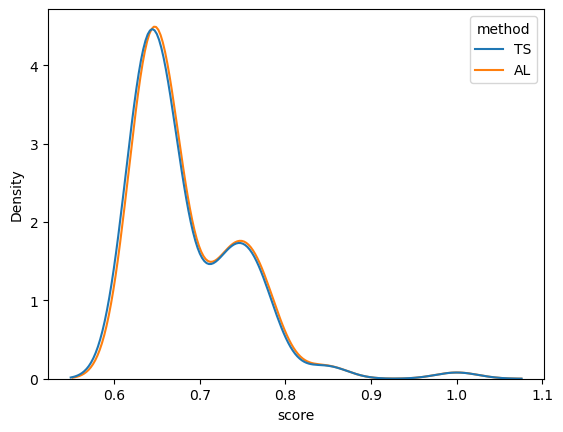

In [18]:
sns.kdeplot(x="score",hue="method",data=melt_df)

Use a t-test to compare the score distributions

In [19]:
t, p = stats.ttest_ind(al_scores, ts_scores)

Define the evaluator class

In [20]:
fp_eval = FPEvaluator({"query_smiles": query_smiles})

Define a class to get the ground truth similarities for all molecules so that we can get the true top 100.

In [21]:
class SmilesEvaluator:
    def __init__(self, eval):
        self.eval = eval
        
    def eval_smiles(self,smiles):
        mol = Chem.MolFromSmiles(smiles)
        return self.eval.evaluate(mol)

In [22]:
smiles_eval = SmilesEvaluator(fp_eval)

Calculate ground truth similarities

In [23]:
enum_df['truth'] = enum_df.SMILES.progress_apply(smiles_eval.eval_smiles)

  0%|          | 0/970299 [00:00<?, ?it/s]

Get the ground truth top 100

In [24]:
ref_df = enum_df.sort_values("truth",ascending=False).head(100).copy()
ref_df.score = ref_df.truth
ref_df

,SMILES,Name,fp,row_id,score,truth
523629,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_1531037,"[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523629,1.000000,1.000000
523615,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_2384694,"[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523615,0.847458,0.847458
523611,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_1576365,"[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523611,0.847458,0.847458
651042,COc1ccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c(...,36404812_146501451_1531037,"[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",651042,0.786885,0.786885
523673,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_1529313,"[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523673,0.779661,0.779661
...,...,...,...,...,...,...
523658,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_901061,"[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523658,0.634921,0.634921
523650,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_2559503,"[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523650,0.634921,0.634921
523631,COC(=O)[C@@H](N)Cc1nc2c(OC)cccc2c(=O)n1[C@@H]1...,389612_146501451_1709620,"[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523631,0.630769,0.630769
523633,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_59569926,"[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523633,0.630769,0.630769


In [25]:
ref_smiles = enum_df.sort_values("truth",ascending=False).head(100).SMILES

Find out how many of the top 100 we found with TS

In [26]:
ts_df.sort_values("score",ascending=False).head(100).query("SMILES in @ref_smiles")

,score,SMILES,Name
0,1.000000,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_1531037
2,0.847458,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_1576365
1,0.847458,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_2384694
11,0.779661,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_1532556
3,0.779661,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_1529313
...,...,...,...
75,0.634921,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_2559503
66,0.634921,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_901061
15,0.630769,COC(=O)[C@H](N)Cc1nc2c(OC)cccc2c(=O)n1[C@@H]1C...,389612_146501451_2560988
17,0.630769,COC(=O)[C@@H](N)Cc1nc2c(OC)cccc2c(=O)n1[C@@H]1...,389612_146501451_1709620


Find out how many of the top 100 we found with AL

In [27]:
al_df.sort_values("score",ascending=False).head(100).query("SMILES in @ref_smiles")

,SMILES,Name,fp,row_id,score
523629,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_1531037,"[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523629,1.000000
523611,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_1576365,"[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523611,0.847458
523615,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_2384694,"[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523615,0.847458
651042,COc1ccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c(...,36404812_146501451_1531037,"[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",651042,0.786885
523638,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_1532556,"[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523638,0.779661
...,...,...,...,...,...
523650,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_2559503,"[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523650,0.634921
523658,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_901061,"[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523658,0.634921
523631,COC(=O)[C@@H](N)Cc1nc2c(OC)cccc2c(=O)n1[C@@H]1...,389612_146501451_1709620,"[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523631,0.630769
523661,COC(=O)[C@H](N)Cc1nc2c(OC)cccc2c(=O)n1[C@@H]1C...,389612_146501451_2560988,"[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",523661,0.630769


Perform 10 TS runs

In [28]:
ts_df_list = []
for i in tqdm(range(0,10)):
    ts_df_list.append(run_ts(quinazoline_dict,hide_progress=True))

  0%|          | 0/10 [00:00<?, ?it/s]

Perform 10 AL runs

In [29]:
al_df_list = []
for i in tqdm(range(0,10)):
    al_df_list.append(greedy_search(enum_df,query_smiles))

  0%|          | 0/10 [00:00<?, ?it/s]

1000 0.45569620253164556
2000 1.0
3000 1.0
4000 1.0
5000 1.0
1000 0.5373134328358209
2000 1.0
3000 1.0
4000 1.0
5000 1.0
1000 0.5606060606060606
2000 1.0
3000 1.0
4000 1.0
5000 1.0
1000 0.4594594594594595
2000 0.7586206896551724
3000 1.0
4000 1.0
5000 1.0
1000 0.4305555555555556
2000 0.765625
3000 1.0
4000 1.0
5000 1.0
1000 0.5735294117647058
2000 0.847457627118644
3000 1.0
4000 1.0
5000 1.0
1000 0.5753424657534246
2000 1.0
3000 1.0
4000 1.0
5000 1.0
1000 0.527027027027027
2000 0.765625
3000 1.0
4000 1.0
5000 1.0
1000 0.47297297297297297
2000 1.0
3000 1.0
4000 1.0
5000 1.0
1000 0.7258064516129032
2000 1.0
3000 1.0
4000 1.0
5000 1.0


Collect the data and annotate for the plots

In [30]:
for i,df in enumerate(al_df_list):
    df['cycle'] = i

In [31]:
al_concat_df = pd.concat(al_df_list).sort_values("score",ascending=False).drop_duplicates("SMILES").head(100)
al_concat_df['cycle'] = 'concat'
al_concat_df['method'] = 'AL'
ts_concat_df = pd.concat(ts_df_list).sort_values("score",ascending=False).drop_duplicates("SMILES").head(100)
ts_concat_df['cycle'] = 'concat'
ts_concat_df['method'] = 'TS'

In [32]:
for i,df in enumerate(ts_df_list):
    df['cycle'] = i

Collect AL data

In [33]:
al_combo_df = pd.concat([x.sort_values("score",ascending=False).head(100) for x in al_df_list])

In [34]:
al_combo_df.cycle.value_counts()

cycle
0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
Name: count, dtype: int64

Collect TS data

In [35]:
ts_combo_df = pd.concat([x.sort_values("score",ascending=False).head(100) for x in ts_df_list])

In [36]:
concat_df = pd.concat([al_concat_df,ts_concat_df])

In [37]:
al_combo_df['method'] = 'AL'
ts_combo_df['method'] = 'TS'

In [38]:
ref_df['method'] = 'ref'
ref_df['cycle'] = 'ref'

In [39]:
all_combo_df = pd.concat([al_combo_df, ts_combo_df, concat_df,ref_df])
all_combo_df.reset_index(drop=True,inplace=True)
all_combo_df.method = pd.Categorical(all_combo_df.method,categories=["TS","AL","ref"],ordered=True)

Plot the scores

<Axes: xlabel='cycle', ylabel='score'>

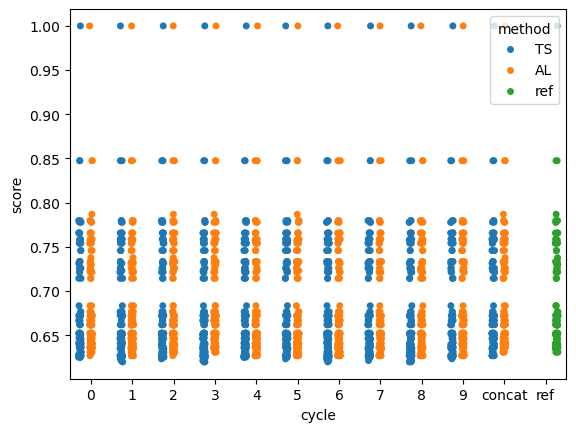

In [40]:
sns.stripplot(x="cycle",y="score",hue="method",dodge=True,data=all_combo_df)

In [41]:
plot_list = []
for cycle in range(0,10):
    num_in_cycle = len(all_combo_df.query("cycle == @cycle and method == 'TS' and SMILES in @ref_smiles"))
    plot_list.append([cycle+1,num_in_cycle,'TS'])

In [42]:
for cycle in range(0,10):
    num_in_cycle = len(all_combo_df.query("cycle == @cycle and method == 'AL' and SMILES in @ref_smiles"))
    plot_list.append([cycle+1,num_in_cycle,"AL"])

In [43]:
plot_list.append(["concat",len(ts_concat_df.query("SMILES in @ref_smiles")),"TS"])
plot_list.append(["concat",len(al_concat_df.query("SMILES in @ref_smiles")),"AL"])

In [44]:
plot_list.append(["ref",100,"ref"])

In [45]:
plot_df = pd.DataFrame(plot_list,columns=["cycle","found","method"])
plot_df.method = pd.Categorical(plot_df.method,categories=["TS","AL","ref"],ordered=True)

Plot the top 100

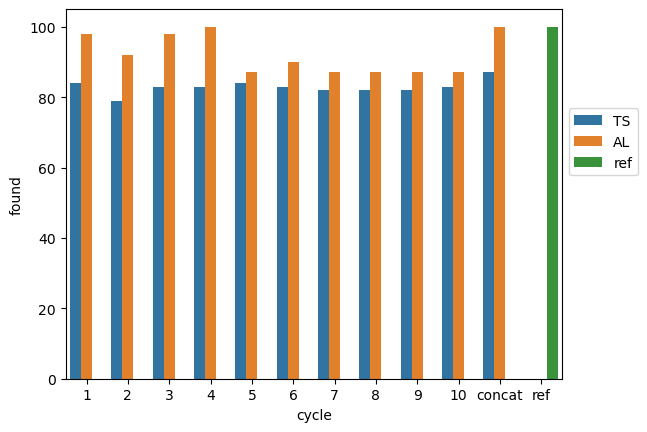

In [46]:
ax = sns.barplot(x="cycle",y="found",hue="method",data=plot_df, dodge=True)
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1);

In [47]:
plot_df.sort_values(["cycle","method"])

,cycle,found,method
0,1,84,TS
10,1,98,AL
1,2,79,TS
11,2,92,AL
2,3,83,TS
12,3,98,AL
3,4,83,TS
13,4,100,AL
4,5,84,TS
14,5,87,AL


Put everything together into one fancy plot

[ 84  98  79  92  83  98  83 100  84  87  83  90  82  87  82  87  82  87
  83  87  87 100 100]


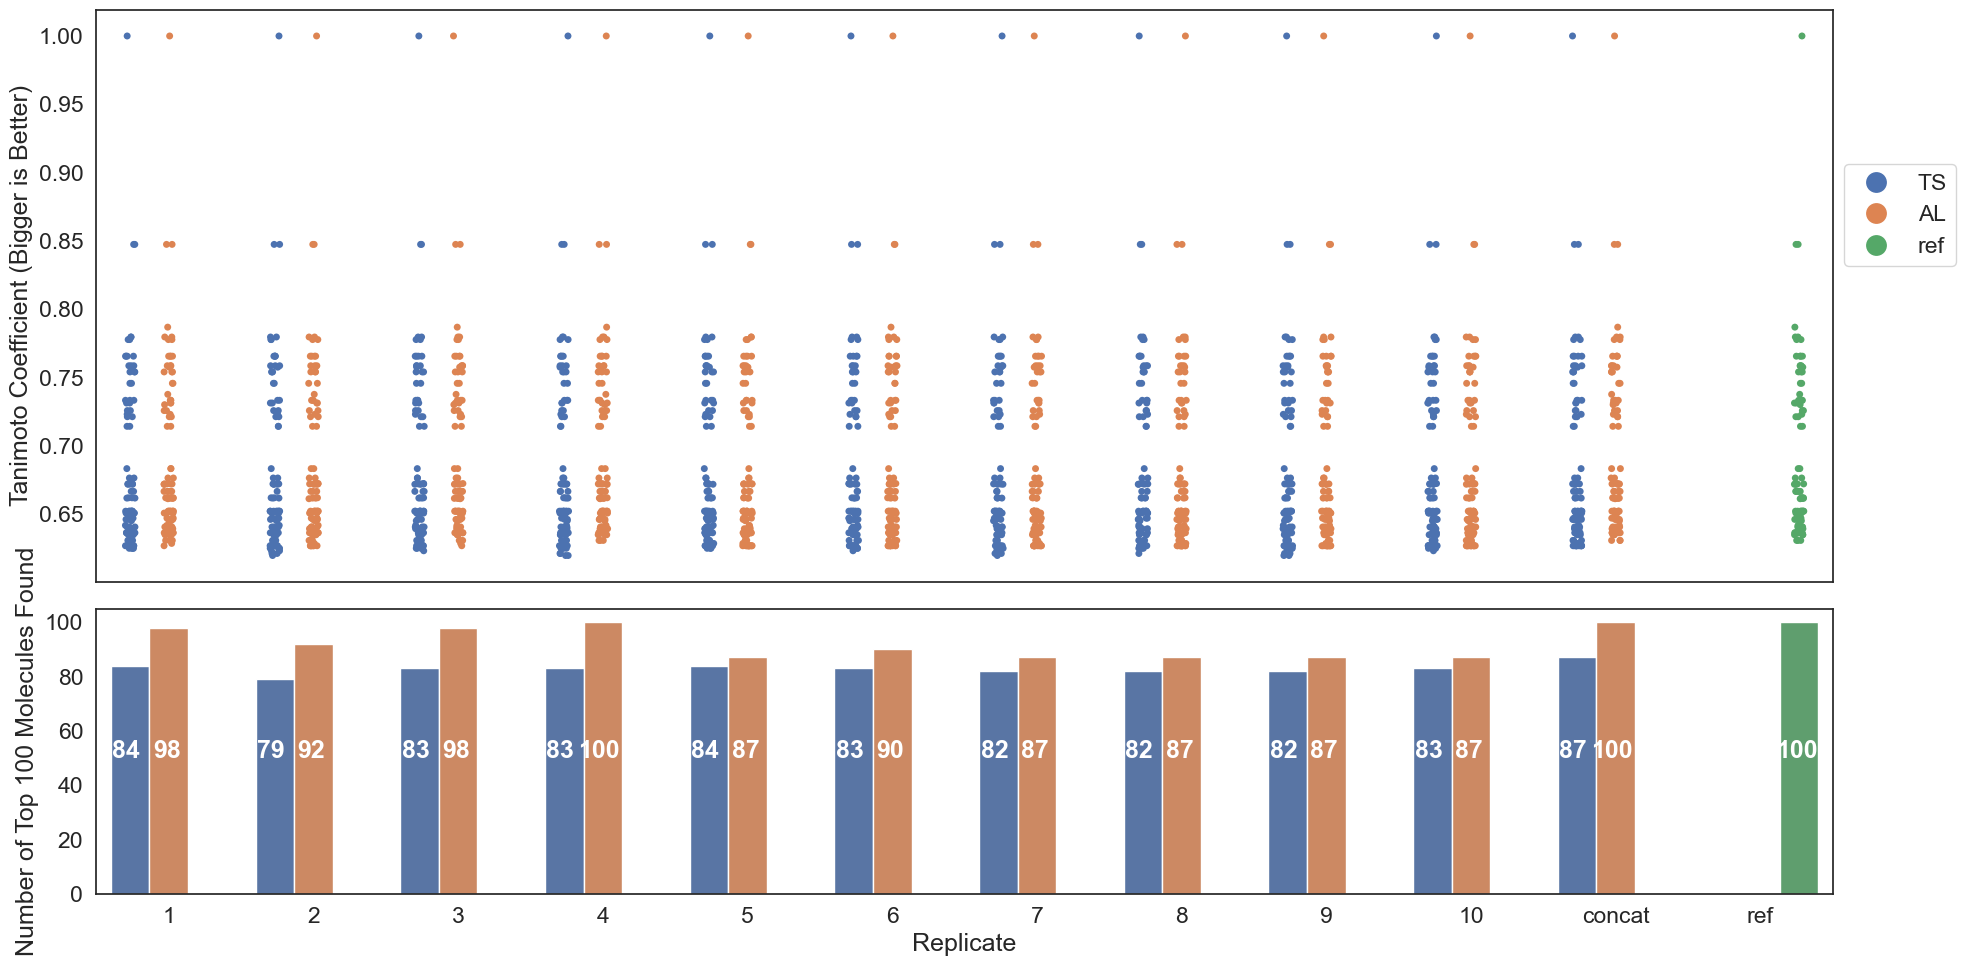

In [48]:
sns.set(font_scale=1.5)
sns.set_style('white')
figure, axes = plt.subplots(2,1,figsize=(20,10),gridspec_kw={'height_ratios': [2, 1]})
ax0 = sns.stripplot(x="cycle",y="score",hue="method",data=all_combo_df,dodge=True,ax=axes[0])
ax0.set_ylabel("Tanimoto Coefficient (Bigger is Better)")
ax0.set_xlabel("Replicate")
ax0.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1);
ax0.set_xlabel(None)
ax0.set_xticks([])
handles = ax0.legend_.legend_handles
for h in handles:
    h.set_markersize(15)

ax1 = sns.barplot(x="cycle",y="found",hue="method",data=plot_df,ax=axes[1])
ax1.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1)
ax1.set_xlabel("Replicate")
ax1.set_ylabel("Number of Top 100 Molecules Found")
ax1.legend_.remove()

labels = plot_df.sort_values(["cycle","method"]).found.values
print(labels)
x_val = -0.39
for i in range(0, 11):
    ax1.text(x_val + 0.0, 50, labels[i * 2], color="white", fontweight="bold")
    label = labels[i*2+1]
    if label >= 100:
        spacing = 0.22
    else:
        spacing = 0.28
    ax1.text(x_val + spacing, 50, labels[i * 2 + 1], color="white", fontweight="bold")
    x_val = x_val + 1
ax1.text(x_val + 0.50, 50, 100, color="white", fontweight="bold")


plt.tight_layout()

Save the results to disk

In [49]:
all_combo_df.to_csv("active_learning_comparison.csv")

Compute p-values for pairwise comparisons and plot the p-values as a heatmap

In [50]:
def get_label(h,i):
    if h == "ref":
        return "ref"
    i = str(i)
    if i.isdigit():
        return h+"_"+str(int(i)+1)
    else:
        return h+"_"+i

In [51]:
all_combo_df['group'] = [get_label(i,j) for (i,j) in all_combo_df[["method","cycle"]].values]

In [52]:
stat_res_list = []
for g1 in all_combo_df.group.unique():
    df1 = all_combo_df.query("group == @g1")
    for g2 in all_combo_df.group.unique():
        df2 = all_combo_df.query("group == @g2 ")
        stat_res_list.append([g1,g2,stats.ttest_ind(df1.score,df2.score).pvalue])
stat_res_df = pd.DataFrame(stat_res_list,columns=["method_1","method_2","p-value"])

In [53]:
stat_res_df["p-value"].min()

0.30744773459953595

In [54]:
all_combo_df.group.unique()

array(['AL_1', 'AL_2', 'AL_3', 'AL_4', 'AL_5', 'AL_6', 'AL_7', 'AL_8',
       'AL_9', 'AL_10', 'TS_1', 'TS_2', 'TS_3', 'TS_4', 'TS_5', 'TS_6',
       'TS_7', 'TS_8', 'TS_9', 'TS_10', 'AL_concat', 'TS_concat', 'ref'],
      dtype=object)

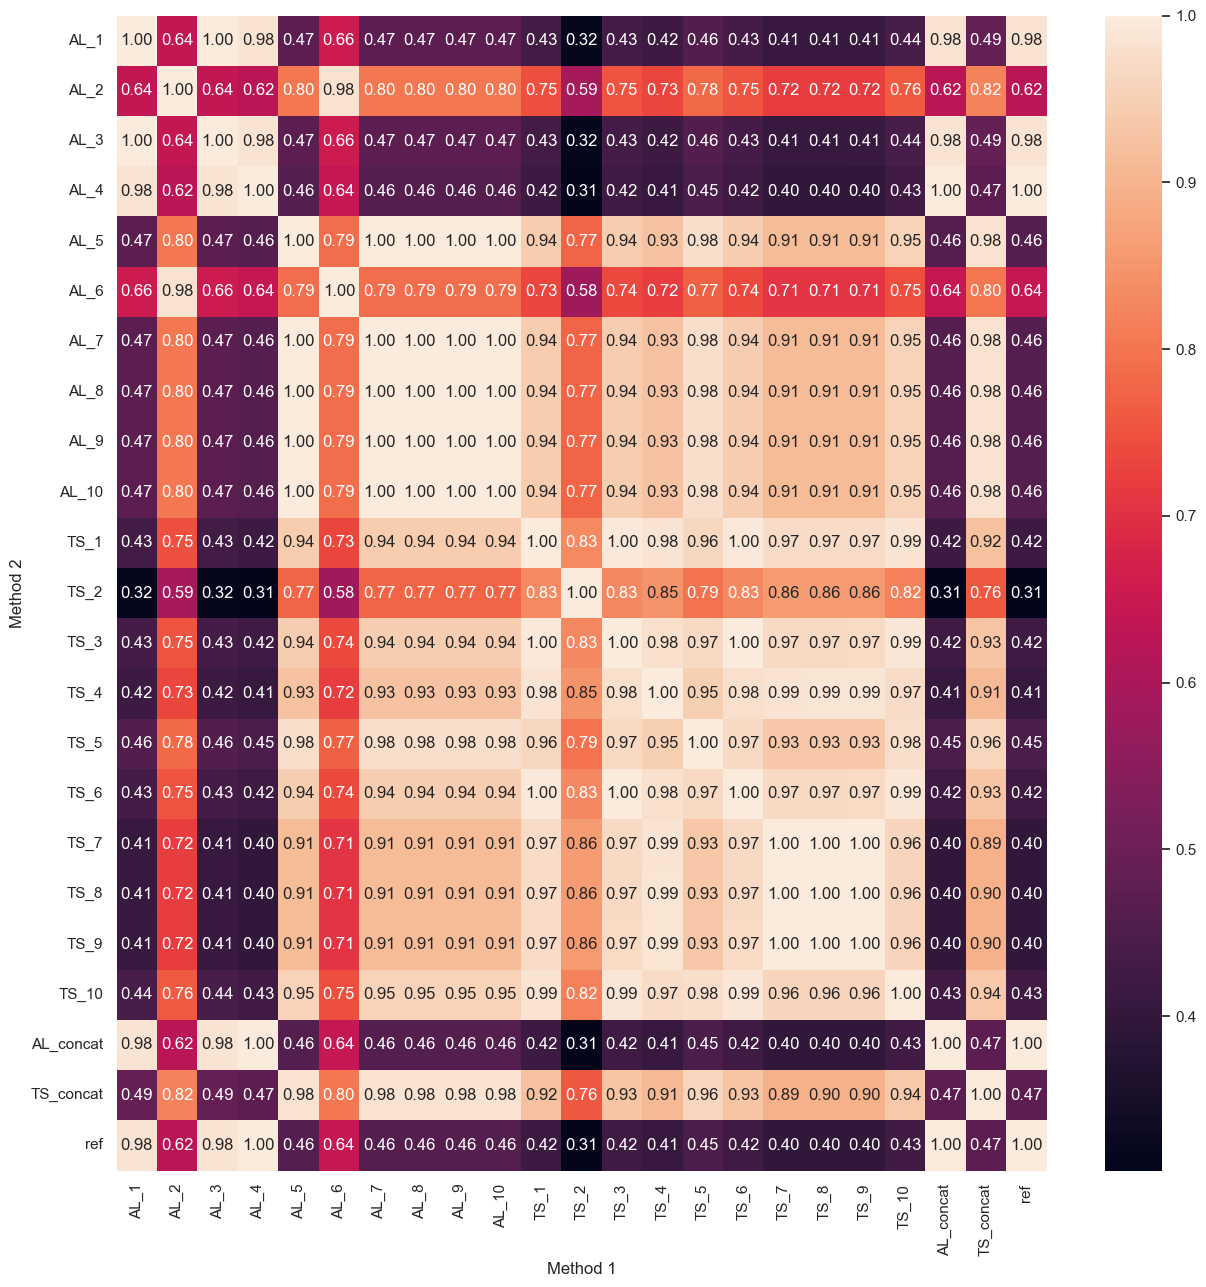

In [55]:
sns.set(font_scale=1.0)
sns.set(rc={'figure.figsize': (15, 15)})
pivot_df = stat_res_df.pivot(index="method_1",columns="method_2",values="p-value")
cats = all_combo_df.group.unique()
pivot_df.index = pd.CategoricalIndex(pivot_df.index, categories= cats)
pivot_df = pivot_df[cats]
pivot_df.sort_index(level=0, inplace=True)
ax = sns.heatmap(pivot_df,annot=True,fmt='.2f')
ax.set_xlabel("Method 1")
ax.set_ylabel("Method 2");